In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import h5py 

### Introduction

In this notebook we use a k-means algorithm to compress an image. 

The basic idea is the following: 

**Memory usage for a RGB image**

Consider a RGB color image comprised of ($N_w \times N_h$) pixels, where $N_w$ and $N_h$ are the width and height of the image in pixels. The color at each pixel is encoded by a three-tuple of integers $\vec c = (c_1, c_2, c_3) \in \{0, ..., 255\}^3$ corresponding to the amount of red, green, and blue at that particular pixel.

To store an integer $c_i \in \{0, ..., 255\}$ we need 8 bit, since $2^8 = 256$. This means for each pixel we need 24 bit (8 for red, 8 for green, 8 for blue). To store a RGB image with $N = N_w \times N_h$ pixels, we thus need to store

\begin{align}
    M &= N_w \cdot N_h \cdot 24 \mathrm{bit}.
\end{align}

**Image compression via k-means**

To compress a RGB image, we reduce the image to a given number of $K$ colors. For this, we consider the $ N_w \cdot N_h$ three-dimensional color vectors defined by the image as a set of vectors in the subset $[0,255]^3$ of three-dimensional Euclidean space. We use the k-means algorithm to identify $K$ clusters (corresponding to the $K$ optimal colors for the image),
and to map every pixel to one of those $K$ colors.

The compressed image is then encoded in the following two datasets:

1. The $K$ cluster centroids/optimal colors, i.e. a set of $K$ vectors $\vec c = (c_1, c_2, c_3) \in \{0, ..., 255\}^3$, and 
2. an integer from $\{0, ..., K-1\}$ for each pixel, which tells us which of the $K$ colors this particular pixel should have.

The storage needed for these datasets is: 

1. The $K$ cluster centroids need $K \times 24$ bit.
2. If $K= 2^k$, then to store the number $\{0,...,K-1\}=\{0,...,2^k\}$ we need $k$ bit. 

Thus, to specify the full compressed image we need 

\begin{align}
    M &= K \cdot 24 \,\mathrm{bit} + N_w \cdot N_h \cdot k\, \mathrm{bit}.
\end{align}

For the example image below, we have $N_w = 1210$, $N_h = 1613$, so that $N_w \times N_h = 1951730$. The maximal value for $K$ we consider is $K = 64 = 2^6$, so that 

\begin{align}
M &= K \cdot 24 \,\mathrm{bit} + N_w \cdot N_h \cdot k\, \mathrm{bit}
\\
&= 64 \cdot 24 \,\mathrm{bit} +1951730 \cdot 6\, \mathrm{bit}
\\ 
&= 1536  \,\mathrm{bit} + 11710380\, \mathrm{bit}
\\
&\approx 1.4\, \mathrm{megabytes}.
\end{align}

Note that the storage of the $K$ cluster centroids is negligible as compared to the pixel data.

The full RGB picture needs 
\begin{align}
N_w \cdot N_h \cdot 24\, \mathrm{bit} &\approx 5.6\, \mathrm{megabytes},
\end{align}

so that with $K = 64$ we compress the image to about one quarter of its original size.

### Import the module

The k-means algorithm is implemented in the file k_means.py in this folder,
which we import now:

In [2]:
from k_means import *
# k_means contains three classes:
# - k_means: k-means algorithm
# - k_means_parallel: parallelized version of k-means
# - image_compression: image compression based on k-means

### Load and show sample image

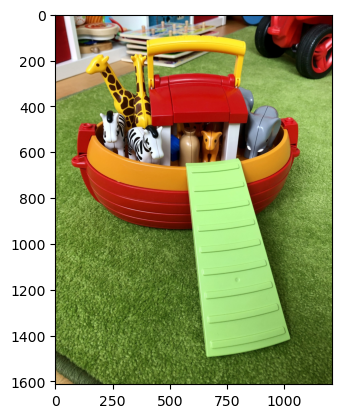

In [3]:
filename ='sample.JPG'
image = mpimg.imread(filename)
plt.imshow(image);

### Compress image

K = 2 finished. Runtime 16.9 seconds


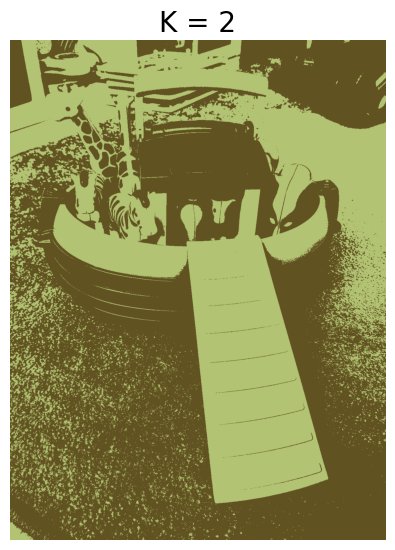

K = 3 finished. Runtime 27.9 seconds


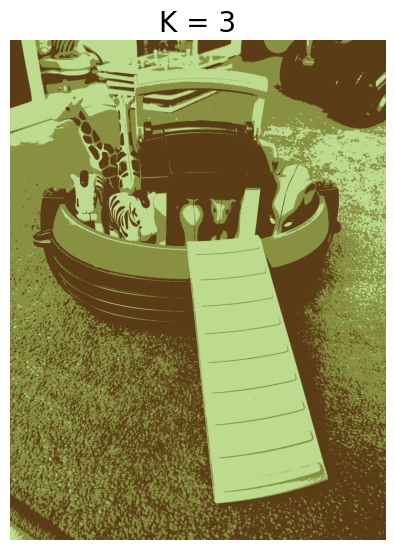

K = 4 finished. Runtime 34.2 seconds


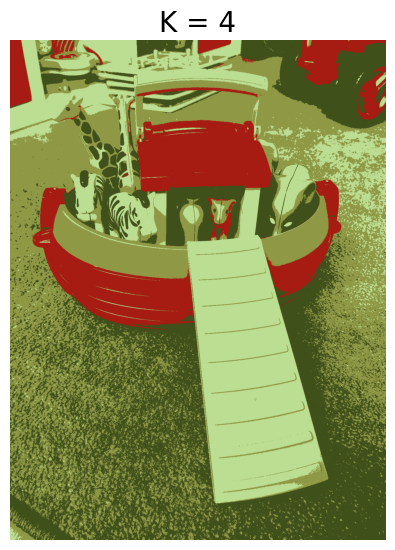

K = 5 finished. Runtime 56.8 seconds


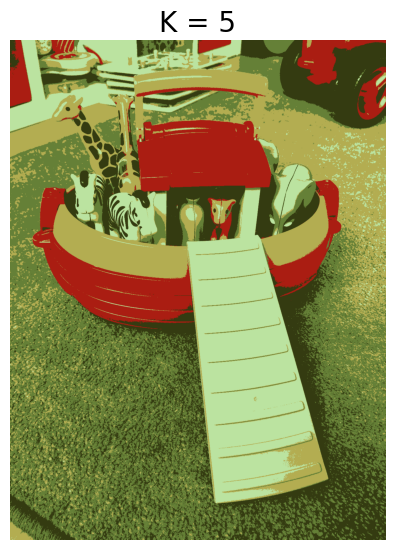

K = 6 finished. Runtime 51.6 seconds


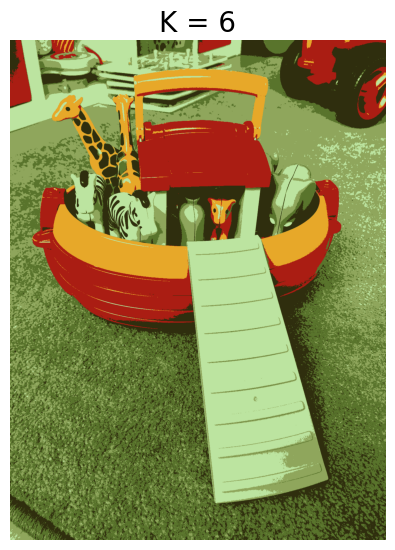

K = 8 finished. Runtime 81.5 seconds


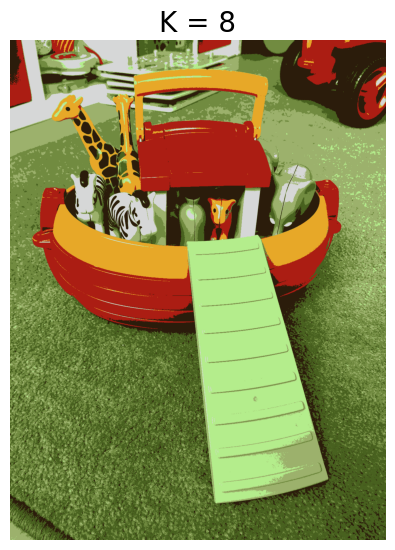

K = 16 finished. Runtime 144.6 seconds


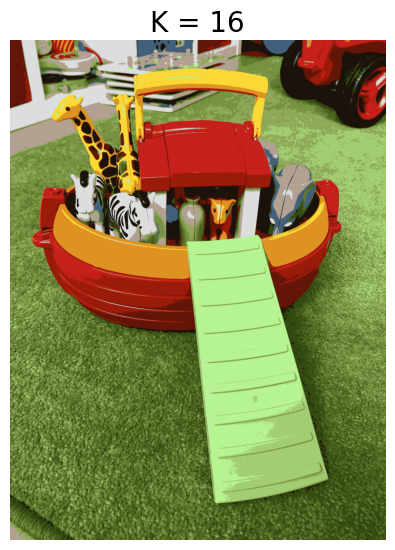

K = 64 finished. Runtime 855.1 seconds


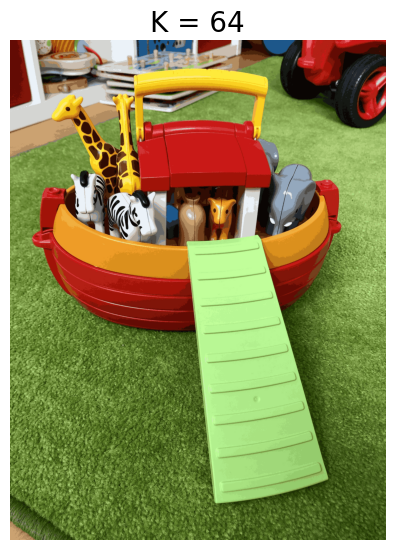

In [4]:
Ks = np.array([2,3,4,5,6,8,16,64],dtype=int)
N_cores = 4 # we run 4 cores in parallel
N_minimization = 4 # for each K, we take the best of 4 compression attempts

ic = image_compression() # instantiate compression algorithm

compressed_image_dictionaries = {}
for i,K in enumerate(Ks): 
    #
    title = 'K = {0}'.format(K) # title for plot
    filename = 'sample_K_{0}.jpg'.format(K) # filename for plot
    #
    print(title,end='\r')
    #
    starting_time = time.time()
    compressed_image_dictionaries[K] = ic.compress_image(image=image,
                                                K=K,
                                                N_cores=N_cores,
                                                N_minimization=N_minimization)
    finishing_time = time.time()
    runtime = finishing_time - starting_time
    compressed_image_dictionaries[K]['runtime'] = runtime
    #
    print("K = {0} finished. Runtime {1:3.1f} seconds".format(K,runtime))
    #
    image_recovered = ic.decompress_image(plot=True,
                                          title=title,
                                          filename=filename,
                                          **compressed_image_dictionaries[K])
    



### Save results to disk

We store the data in the hdf5 file format

In [5]:
with h5py.File('sample_compressed.h5', 'w') as hf:
    for K, results in compressed_image_dictionaries.items():
        hf0 = hf.create_group(str(K))
        for key, value in results.items():
            if len(np.shape(value)) == 0: 
                compression = None # scalar data does not support compression
            else:
                compression = 'lzf'
            hf0.create_dataset(name=str(key),data=value,
                              compression=compression)

### For comparison, we do the same analysis with sklearn

In [6]:
import sklearn.cluster

K = 2 finished. Runtime 1.6 seconds


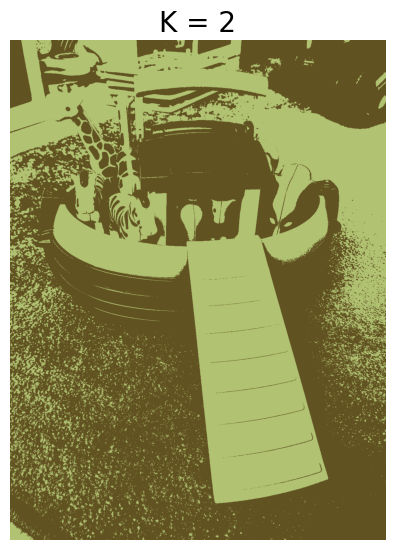

K = 3 finished. Runtime 1.9 seconds


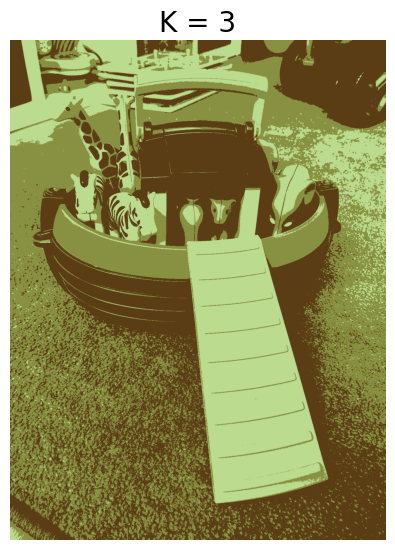

K = 4 finished. Runtime 2.0 seconds


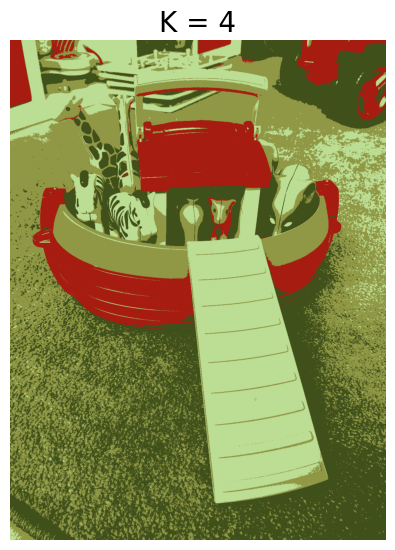

K = 5 finished. Runtime 2.6 seconds


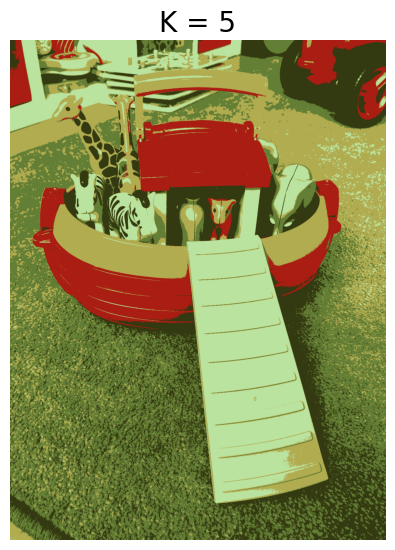

K = 6 finished. Runtime 2.8 seconds


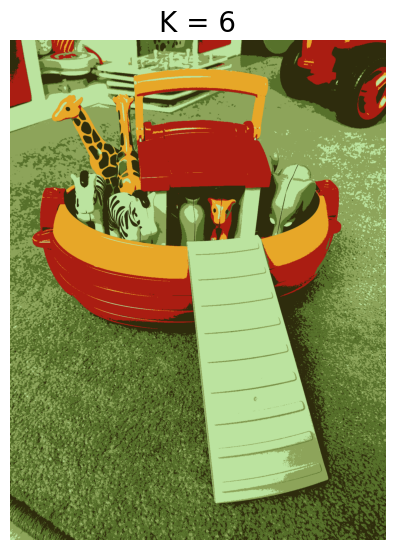

K = 8 finished. Runtime 2.9 seconds


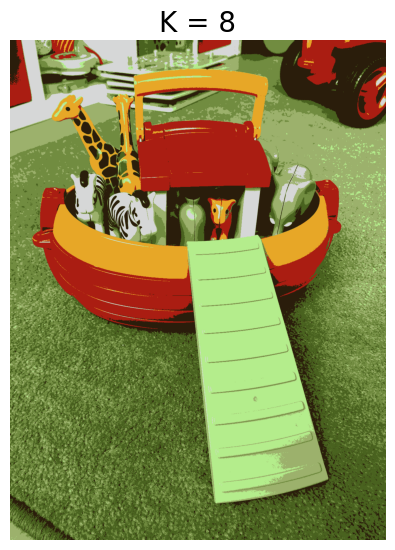

K = 16 finished. Runtime 4.9 seconds


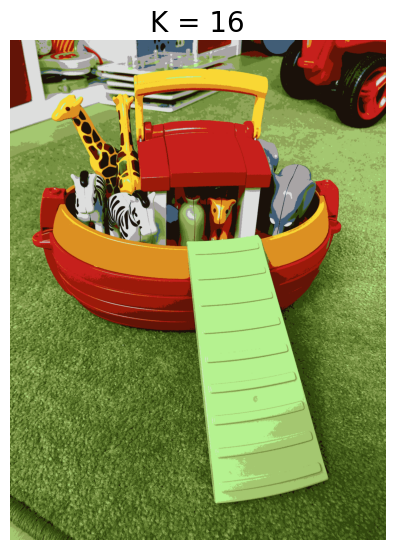

K = 64 finished. Runtime 19.2 seconds


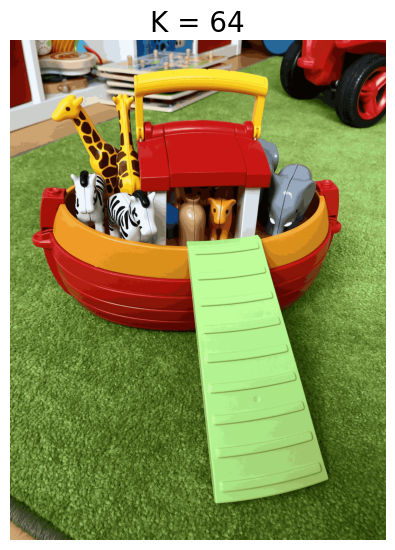

In [7]:
Nx, Ny, Nz = image.shape
image_flattened = image.reshape([Nx*Ny,Nz])


compressed_image_dictionaries_sklearn = {}
for i,K in enumerate(Ks): 
    #
    kmeans = sklearn.cluster.KMeans(n_clusters=K,
                                    n_init=N_minimization)
    #
    title = 'K = {0}'.format(K) # title for plot
    filename = 'sample_K_{0}.jpg'.format(K) # filename for plot
    #
    print(title,end='\r')
    #
    starting_time = time.time()
    kmeans.fit(X=image_flattened)
    finishing_time = time.time()
    #
    runtime = finishing_time - starting_time
    compressed_image_dictionaries_sklearn[K] = {'K':K,
                        'N_minimizations':N_minimization,
                        'colors':kmeans.cluster_centers_,
                        'image_compressed':kmeans.labels_.reshape([Nx,Ny]),
                                            }
    compressed_image_dictionaries_sklearn[K]['runtime'] = runtime
    #
    print("K = {0} finished. Runtime {1:3.1f} seconds".format(K,runtime))
    #
    decompress_image(plot=True,
                    title=title,
                    filename=filename,
                    **compressed_image_dictionaries_sklearn[K])